model 3 is our main model

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf

In [78]:
tech_list = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG'] #^GSPC is the S&P 500

end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = datetime(end.year - 1, end.month, end.day)

# Downloading data for each stock and storing it in a dictionary
stock_data = {}
for stock in tech_list:
    stock_data[stock] = yf.download(stock, start, end)


for stock in stock_data:
    stock_data[stock].rename(columns={"Adj Close": "Adjusted Close"}, inplace=True)

# Assigning each DataFrame to a variable for convenience
SP500 = stock_data['^GSPC']
AAPL = stock_data['AAPL']
MSFT = stock_data['MSFT']
AMZN = stock_data['AMZN']
NVDA = stock_data['NVDA']
GOOGL = stock_data['GOOGL']
TSLA = stock_data['TSLA']
GOOG = stock_data['GOOG']

# Adding company_name to each DataFrame and concatenating them
company_list = [SP500, AAPL, MSFT, AMZN, NVDA, GOOGL, TSLA, GOOG]
company_name = ["SP500", "APPLE", "MICROSOFT", "AMAZON", "NVIDIA", "GOOGLE", "TESLA", "ALPHABET"]

for df, com_name in zip(company_list, company_name):
    df["company_name"] = com_name

# Concatenating all DataFrames
df = pd.concat(company_list, axis=0)

print(df['company_name'].unique())
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

['SP500' 'APPLE' 'MICROSOFT' 'AMAZON' 'NVIDIA' 'GOOGLE' 'TESLA' 'ALPHABET']
                  Open        High         Low       Close  Adjusted Close  \
Date                                                                         
2024-07-25  174.250000  175.199997  169.050003  169.160004      169.160004   
2024-07-26  168.770004  169.839996  165.865005  168.679993      168.679993   
2024-07-29  170.500000  172.160004  169.720001  171.130005      171.130005   
2024-07-30  171.830002  172.949997  170.119995  171.860001      171.860001   
2024-07-31  174.919998  175.910004  171.720001  173.149994      173.149994   
2024-08-01  171.979996  175.679993  170.509995  172.449997      172.449997   
2024-08-02  168.190002  170.210007  166.389999  168.399994      168.399994   
2024-08-05  157.369995  165.940002  156.600006  160.639999      160.639999   
2024-08-06  160.945007  162.350006  158.130005  160.539993      160.539993   
2024-08-07  163.240005  164.789993  160.240005  160.750000      16

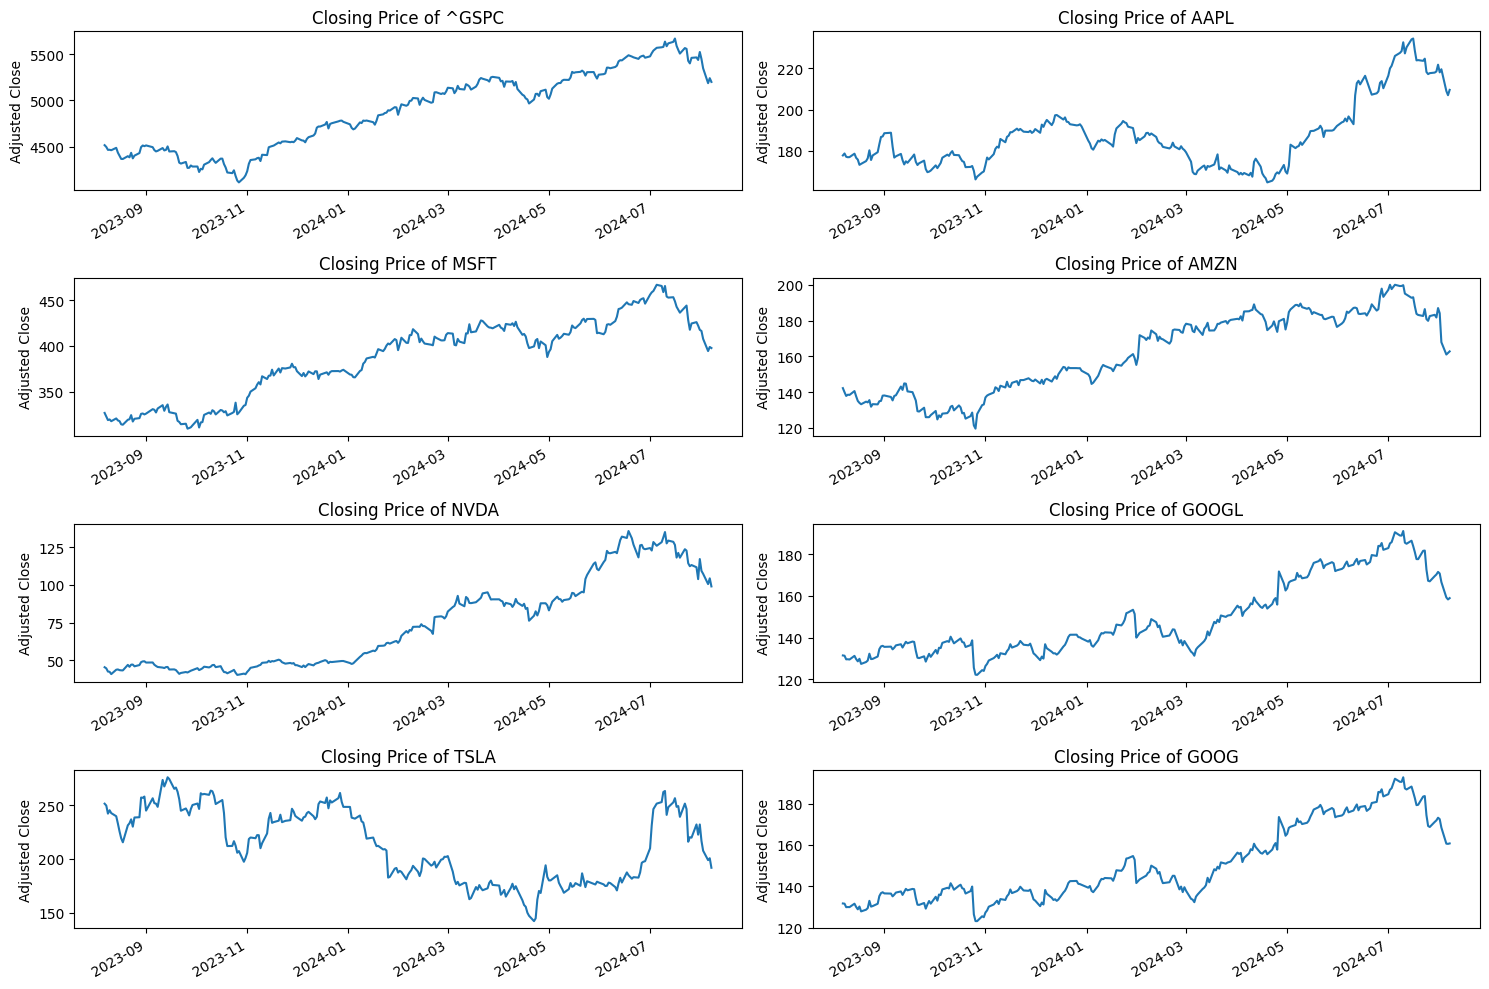

In [79]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(4, 2, i)
    company['Adjusted Close'].plot()
    plt.ylabel('Adjusted Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

1. **General Upward Trend (November 2023 - June 2024):**
   - **Stocks and Index:** All displayed a general upward trend during this period.

2. **Peak (Around July 2024):**
   - **Stocks and Index:** All three stocks and the S&P 500 index reached their respective peaks around July 2024.

3. **Post-Peak Decline:**
   - **Stocks and Index:** After peaking in July 2024, all stocks and the S&P 500 index experienced a notable decline.

4. **Trend Similarity:**
   - **Microsoft & S&P 500:** Among the stocks, Microsoft's trend was the most similar to that of the S&P 500 index.


In [80]:
# Fetch the adjusted closing prices for the tech stocks
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', '^GSPC']
closing_df = yf.download(tickers, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()

[*********************100%%**********************]  8 of 8 completed


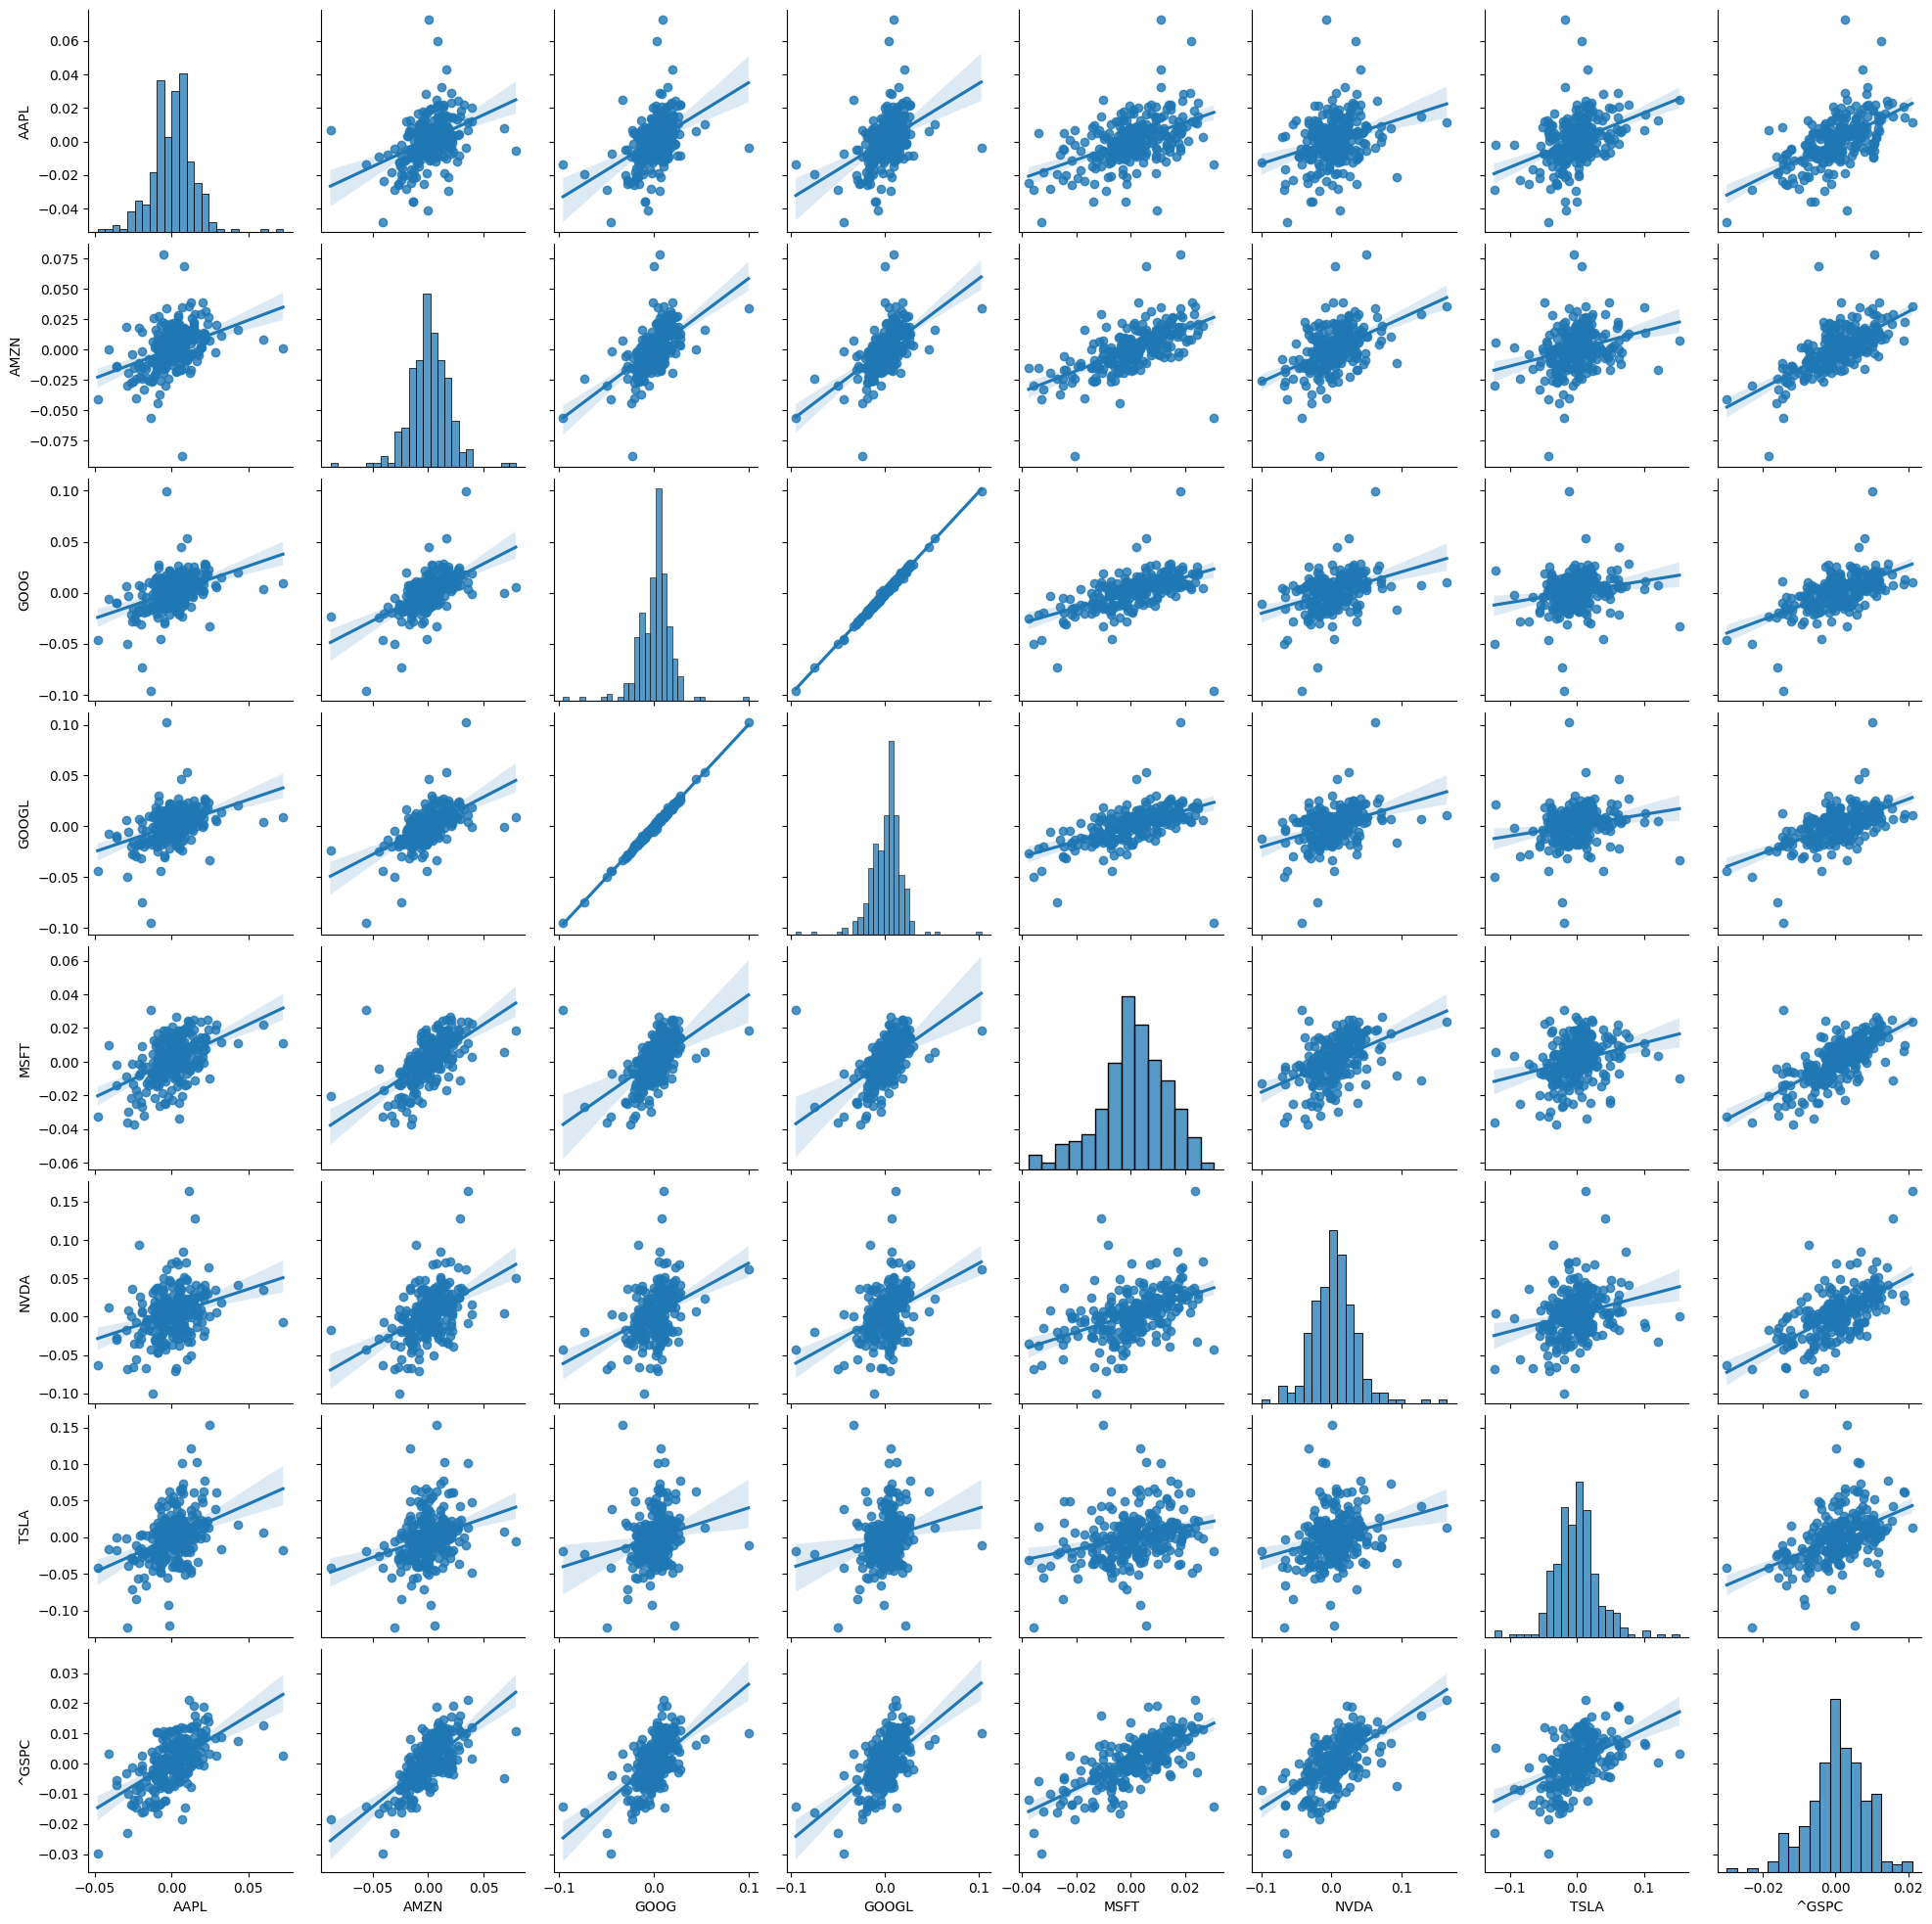

In [81]:
sns.pairplot(tech_rets, kind='reg')

Text(0.5, 1.0, 'Correlation of stock daily return')

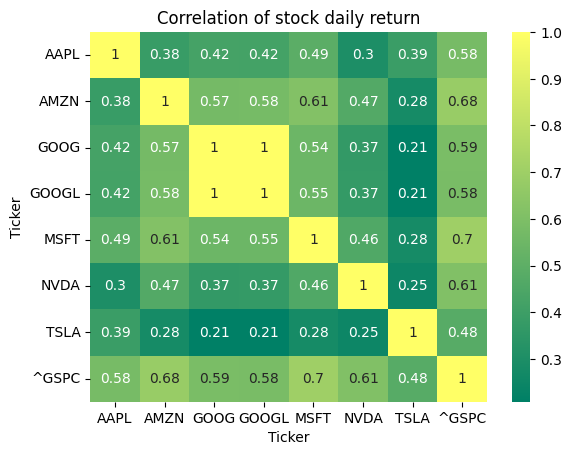

In [82]:
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock daily return')

We can see that our target is correlated (above 0.48) with the daily return of these stocks, and Microsoft is the most correlated one. Let's visualize the daily return percentages (the 3 most correlated stocks with the S&P 500)

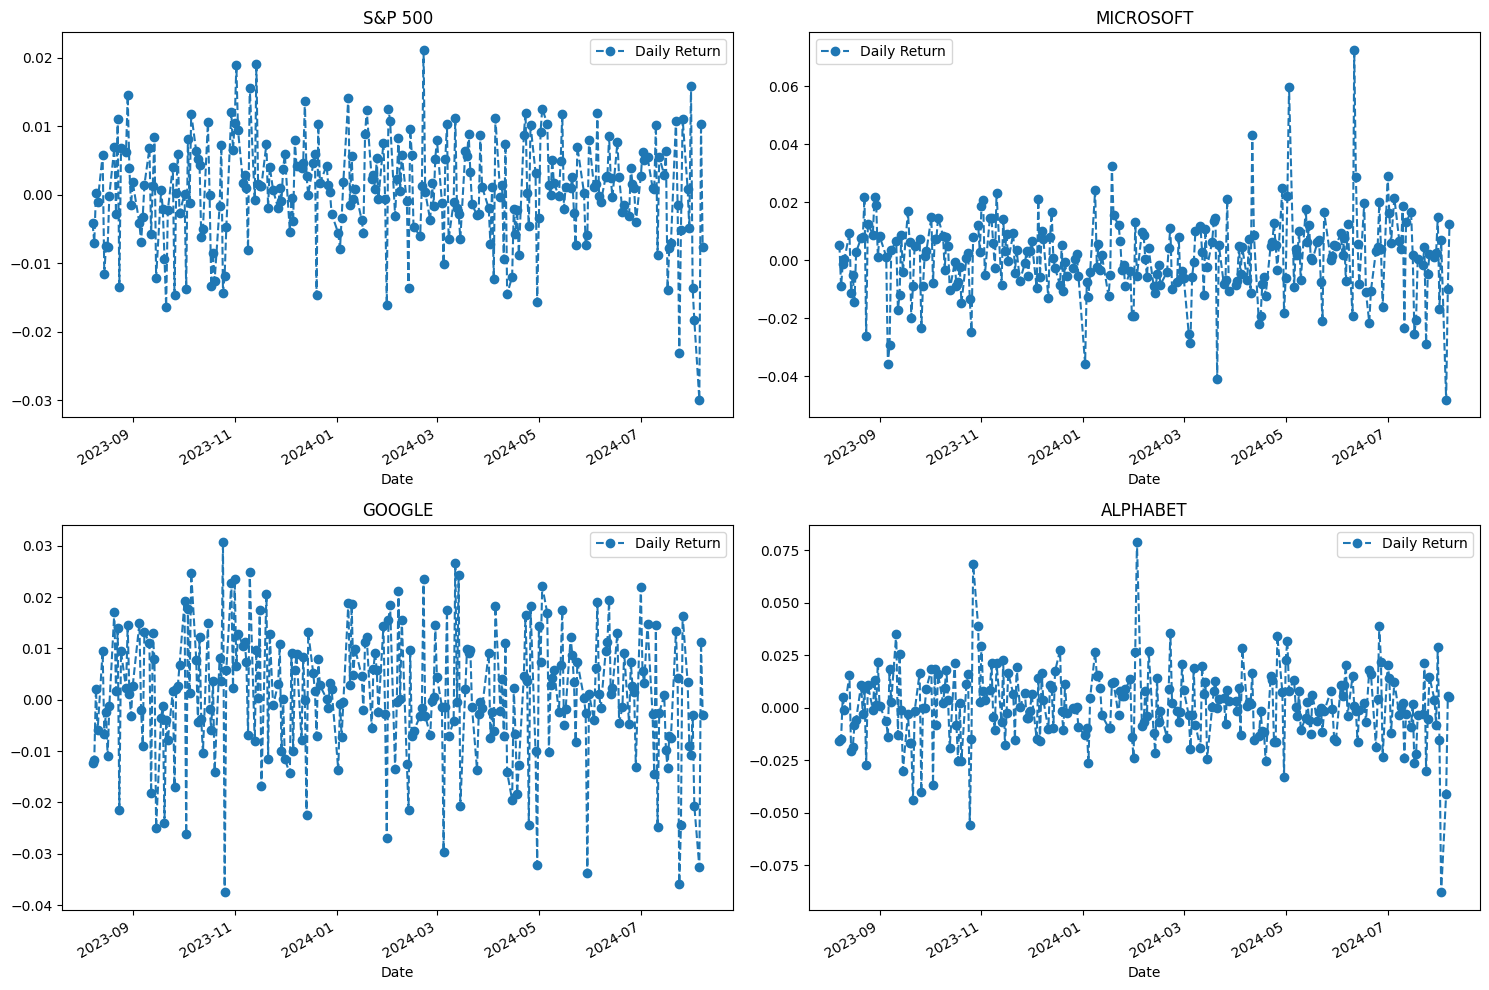

In [83]:
for company in company_list:
    company['Daily Return'] = company['Adjusted Close'].pct_change()

# Plotting the daily return percentages
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

SP500['Daily Return'].plot(ax=axes[0, 0], legend=True, linestyle='--', marker='o')
axes[0, 0].set_title('S&P 500')

AAPL['Daily Return'].plot(ax=axes[0, 1], legend=True, linestyle='--', marker='o')
axes[0, 1].set_title('MICROSOFT')

MSFT['Daily Return'].plot(ax=axes[1, 0], legend=True, linestyle='--', marker='o')
axes[1, 0].set_title('GOOGLE')

AMZN['Daily Return'].plot(ax=axes[1, 1], legend=True, linestyle='--', marker='o')
axes[1, 1].set_title('ALPHABET')

fig.tight_layout()
plt.show()

Let's now to fetch the daily return of these stocks and use them as features to train our model.

In [84]:
end = end
start = '2000-01-01'

# Fetch adjusted close prices for Apple, Amazon, and Microsoft...
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG' ]
data = {}

for ticker in tickers:
    stock_data = yf.download(ticker, start=start, end=end)
    adj_close = stock_data['Adj Close']
    data[ticker] = adj_close.rename(ticker)

# Merge the data into a single DataFrame
merged_data = pd.concat(data.values(), axis=1)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [85]:
merged_data.dropna(inplace=True)

for column in merged_data.columns:
    merged_data[f'{column} DR'] = merged_data[column].pct_change()

merged_data.dropna(inplace=True)

print(merged_data.head())


                AAPL    AMZN       MSFT      NVDA      GOOGL      TSLA  \
Date                                                                     
2010-06-30  7.586102  5.4630  17.517588  0.234122  11.122120  1.588667   
2010-07-01  7.494116  5.5480  17.631783  0.238020  10.985640  1.464000   
2010-07-02  7.447671  5.4570  17.715530  0.235039  10.912151  1.280000   
2010-07-06  7.498638  5.5030  18.134247  0.232517  10.900153  1.074000   
2010-07-07  7.801445  5.6715  18.499678  0.243753  11.253350  1.053333   

                 GOOG   AAPL DR   AMZN DR   MSFT DR   NVDA DR  GOOGL DR  \
Date                                                                      
2010-06-30  11.069613 -0.018113  0.005985 -0.012870 -0.025763 -0.020495   
2010-07-01  10.933779 -0.012126  0.015559  0.006519  0.016651 -0.012271   
2010-07-02  10.860637 -0.006198 -0.016402  0.004750 -0.012524 -0.006689   
2010-07-06  10.848695  0.006843  0.008430  0.023636 -0.010732 -0.001100   
2010-07-07  11.200226  0.040382

In [86]:
#keep only the daily return columns
columns_to_drop = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA',  'GOOG']
data = {}

merged_data.drop(columns=columns_to_drop, inplace=True)

print(merged_data.head())

             AAPL DR   AMZN DR   MSFT DR   NVDA DR  GOOGL DR   TSLA DR  \
Date                                                                     
2010-06-30 -0.018113  0.005985 -0.012870 -0.025763 -0.020495 -0.002511   
2010-07-01 -0.012126  0.015559  0.006519  0.016651 -0.012271 -0.078473   
2010-07-02 -0.006198 -0.016402  0.004750 -0.012524 -0.006689 -0.125683   
2010-07-06  0.006843  0.008430  0.023636 -0.010732 -0.001100 -0.160937   
2010-07-07  0.040382  0.030620  0.020151  0.048323  0.032403 -0.019243   

             GOOG DR  
Date                  
2010-06-30 -0.020495  
2010-07-01 -0.012271  
2010-07-02 -0.006690  
2010-07-06 -0.001100  
2010-07-07  0.032403  


Fetch the sp500 data from yahoo finance and add some technical indicators as well.

1. **Relative Strength Index (RSI):** Measures momentum and helps identify overbought or oversold conditions, which can signal potential reversals.

2. **Exponential Moving Averages (EMA - Fast, Medium, Slow):** Highlight short-term, medium-term, and long-term trends by giving more weight to recent prices, helping to track market direction over different time horizons.

3. **Simple Moving Averages (SMA - 30, 100):** Provide a smoothed view of price trends over different periods, aiding in trend identification and potential reversal points.

4. **Bollinger Bands (High/Low):** Measure market volatility and potential breakout points, helping the model understand periods of high or low volatility.

5. **Average True Range (ATR):** Gauges market volatility by considering price ranges, which is crucial for understanding market dynamics and potential price movements.

6. **Moving Average Convergence Divergence (MACD):** Captures momentum and trend direction, highlighting potential buy or sell signals based on the convergence and divergence of moving averages.

Including these indicators enriches the feature set, allowing the model to capture various aspects of market behavior such as trend, momentum, and volatility.

In [87]:
end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = '2000-01-01'

sp500_data = yf.download('^GSPC', start=start, end=end)


# Add technical indicators
sp500_data['Rsi'] = ta.rsi(sp500_data['Adj Close'], length=14)  
sp500_data['Ema_fast'] = ta.ema(sp500_data['Adj Close'], length=12)  
sp500_data['Ema_medium'] = ta.ema(sp500_data['Adj Close'], length=26)  
sp500_data['Ema_slow'] = ta.ema(sp500_data['Adj Close'], length=50) 
sp500_data['Sma_30'] = ta.sma(sp500_data['Adj Close'], length=30)  
sp500_data['Sma_100'] = ta.sma(sp500_data['Adj Close'], length=100)  

sp500_data['Bollinger_High'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBU_20_2.0']
sp500_data['Bollinger_Low'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBL_20_2.0']

sp500_data['ATR'] = ta.atr(sp500_data['High'], sp500_data['Low'], sp500_data['Adj Close'], length=14)
sp500_data['MACD'] = ta.macd(sp500_data['Adj Close'], fast=12, slow=26, signal=9)['MACD_12_26_9']

print(sp500_data.head(7))

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   
2000-01-10  1441.469971  1464.359985  1441.469971  1457.599976  1457.599976   
2000-01-11  1457.599976  1458.660034  1434.420044  1438.560059  1438.560059   

                Volume  Rsi  Ema_fast  Ema_medium  Ema_slow  Sma_30  Sma_100  \
Date                                                                           
2000-01-03   931800000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-04  1009000000  NaN       NaN         Na

Notice Date is the index, and weekends are missing.

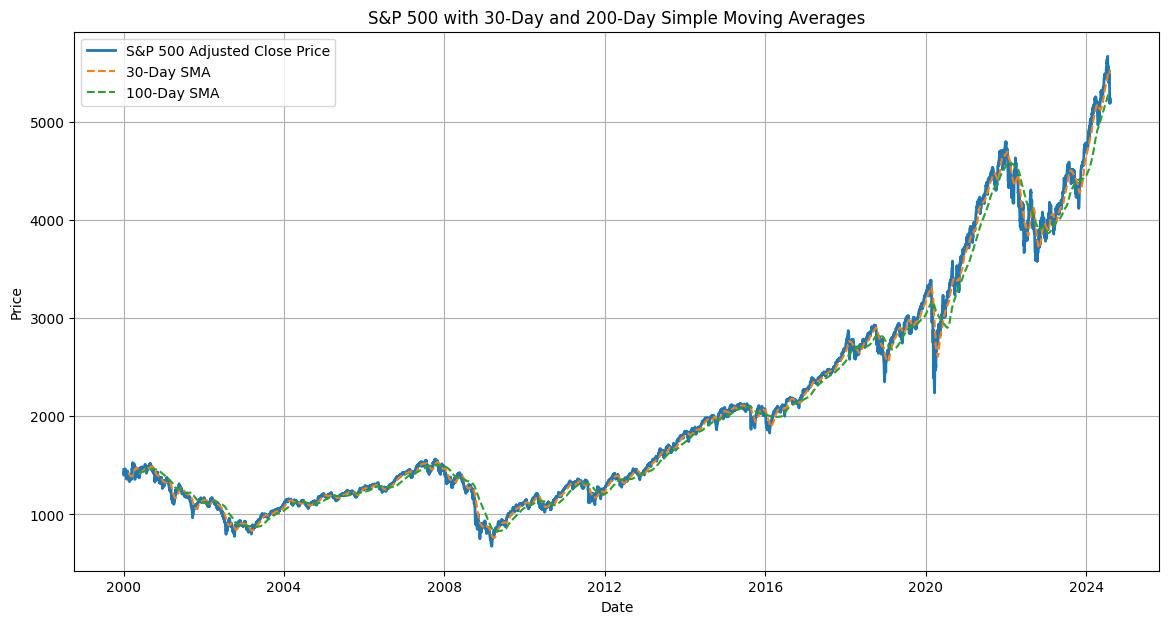

In [88]:
plt.figure(figsize=(14, 7))
plt.plot(sp500_data['Adj Close'], label='S&P 500 Adjusted Close Price', linewidth=2)
plt.plot(sp500_data['Sma_30'], label='30-Day SMA', linestyle='--', linewidth=1.5)
plt.plot(sp500_data['Sma_100'], label='100-Day SMA', linestyle='--', linewidth=1.5)
plt.title('S&P 500 with 30-Day and 200-Day Simple Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

We can see both the 30-day and 100-day Simple Moving Averages (SMAs) capturing the overall trend of the S&P 500 well.

In [89]:
merged_data = pd.concat([sp500_data, merged_data], axis=1).dropna()

print(merged_data.shape)
print(merged_data.columns)

(3550, 23)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Rsi',
       'Ema_fast', 'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100',
       'Bollinger_High', 'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR',
       'MSFT DR', 'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR'],
      dtype='object')


Let's check the correlation between economic features and our target to determine if they should be included to improve our model's performance.

In [90]:
# Fetch economic data
gdp = pdr.get_data_fred('GDP', start=start, end=end) #quaterly
inflation = pdr.get_data_fred('CPIAUCSL', start=start, end=end)  # CPI for inflation
unemployment = pdr.get_data_fred('UNRATE', start=start, end=end)
interest_rate = pdr.get_data_fred('FEDFUNDS', start=start, end=end)

# Rename columns for clarity
gdp.rename(columns={'GDP': 'GDP'}, inplace=True)
inflation.rename(columns={'CPIAUCSL': 'Inflation'}, inplace=True)
unemployment.rename(columns={'UNRATE': 'Unemployment'}, inplace=True)
interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'}, inplace=True)
GDP = gdp.resample('D').ffill()
Inflation = inflation.resample('D').ffill()
Unemployment = unemployment.resample('D').ffill()
Interest_rate = interest_rate.resample('D').ffill()

merged_data = merged_data.join([Inflation, Unemployment, Interest_rate, GDP], how='left')

print(merged_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Rsi',
       'Ema_fast', 'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100',
       'Bollinger_High', 'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR',
       'MSFT DR', 'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Inflation',
       'Unemployment', 'Interest_Rate', 'GDP'],
      dtype='object')


Adding lagged features allows the model to capture temporal dependencies and trends in the data, improving its ability to recognize patterns over time. By incorporating historical values, such as lagged 'Adj Close', 'Rsi', and 'MACD', we wish to enhance the model's predictive power and capture the underlying dynamics of the stock market.

In [91]:
n_lags = 3
for col in ['Adj Close', 'Rsi', 'MACD']:
    for lag in range(1, n_lags + 1):
        merged_data[f'{col}_lag_{lag}'] = merged_data[col].shift(lag)


merged_data['Target'] = merged_data['Adj Close'].pct_change()

merged_data.dropna(inplace=True)
merged_data.reset_index(inplace = True)
Date = merged_data['Date']
merged_data.drop([ 'Date', 'Volume'], axis=1, inplace=True)
print(merged_data.head())

          Open         High          Low        Close    Adj Close        Rsi  \
0  1028.089966  1042.500000  1018.349976  1028.060059  1028.060059  32.767748   
1  1028.540039  1060.890015  1028.540039  1060.270020  1060.270020  45.156109   
2  1062.920044  1071.250000  1058.239990  1070.250000  1070.250000  48.332802   
3  1070.500000  1078.160034  1068.099976  1077.959961  1077.959961  50.708161   
4  1077.229980  1080.780029  1070.449951  1078.750000  1078.750000  50.956973   

      Ema_fast   Ema_medium     Ema_slow       Sma_30  ...  Adj Close_lag_1  \
0  1055.252067  1076.029172  1097.563245  1077.334996  ...      1022.580017   
1  1056.024059  1074.861827  1096.100766  1076.888995  ...      1028.060059   
2  1058.212666  1074.520210  1095.087010  1076.762994  ...      1060.270020   
3  1061.250711  1074.775007  1094.415361  1077.096661  ...      1070.250000   
4  1063.942909  1075.069450  1093.801033  1076.286326  ...      1077.959961   

   Adj Close_lag_2  Adj Close_lag_3  R

<Axes: >

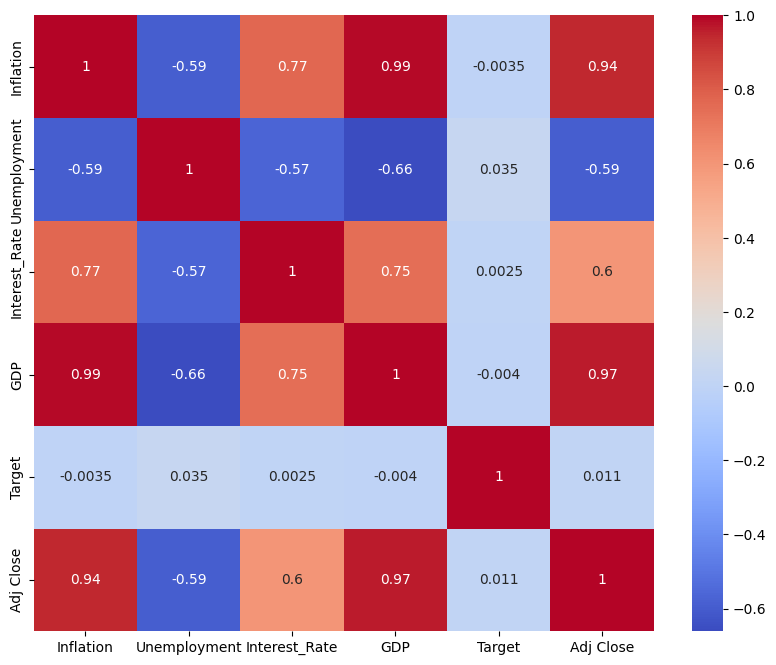

In [92]:
dd = merged_data[['Inflation', 'Unemployment', 'Interest_Rate', 'GDP', 'Target', 'Adj Close']]

plt.figure(figsize=(10, 8))
sns.heatmap(dd.corr(), annot=True, cmap='coolwarm')

We can see these economic features are not correlated with our target, so we will not include them in our model.

In [93]:
merged_data.drop(['Inflation', 'Unemployment', 'Interest_Rate', 'GDP'], axis=1, inplace=True)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             3458 non-null   float64
 1   High             3458 non-null   float64
 2   Low              3458 non-null   float64
 3   Close            3458 non-null   float64
 4   Adj Close        3458 non-null   float64
 5   Rsi              3458 non-null   float64
 6   Ema_fast         3458 non-null   float64
 7   Ema_medium       3458 non-null   float64
 8   Ema_slow         3458 non-null   float64
 9   Sma_30           3458 non-null   float64
 10  Sma_100          3458 non-null   float64
 11  Bollinger_High   3458 non-null   float64
 12  Bollinger_Low    3458 non-null   float64
 13  ATR              3458 non-null   float64
 14  MACD             3458 non-null   float64
 15  AAPL DR          3458 non-null   float64
 16  AMZN DR          3458 non-null   float64
 17  MSFT DR       

In [94]:
features= merged_data.drop(['Target'], axis=1)
features = features.columns
print(features)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Rsi', 'Ema_fast',
       'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100', 'Bollinger_High',
       'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR', 'MSFT DR',
       'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Adj Close_lag_1',
       'Adj Close_lag_2', 'Adj Close_lag_3', 'Rsi_lag_1', 'Rsi_lag_2',
       'Rsi_lag_3', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3'],
      dtype='object')


Since we have so many features, we will perform PCA to reduce the dimensionality of our data. As PCA is sensitive to the scale of the data, we will first standardize the features before applying PCA.

In [95]:
x = merged_data.loc[:, features].values
y = merged_data.loc[:,['Target']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [96]:
pd.DataFrame(data = x, columns = features).head()

,Open,High,Low,Close,Adj Close,Rsi,Ema_fast,Ema_medium,Ema_slow,Sma_30,...,GOOG DR,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Rsi_lag_1,Rsi_lag_2,Rsi_lag_3,MACD_lag_1,MACD_lag_2,MACD_lag_3
0,-1.465795,-1.457302,-1.469557,-1.466121,-1.466121,-2.043697,-1.440759,-1.420562,-1.397795,-1.418138,...,-0.117281,-1.470775,-1.466040,-1.462631,-2.263661,-2.177838,-2.118851,-0.904396,-0.830440,-0.743801
1,-1.465383,-1.440568,-1.460177,-1.436651,-1.436651,-0.936758,-1.440050,-1.421639,-1.399153,-1.418550,...,1.829241,-1.465758,-1.470427,-1.465691,-2.041491,-2.261520,-2.175825,-0.940429,-0.903940,-0.830003
2,-1.433921,-1.431142,-1.432837,-1.427521,-1.427521,-0.652911,-1.438040,-1.421954,-1.400095,-1.418667,...,0.767393,-1.436273,-1.465408,-1.470081,-0.935262,-2.039470,-2.259464,-0.877273,-0.939983,-0.903525
3,-1.426985,-1.424854,-1.423761,-1.420466,-1.420466,-0.440665,-1.435250,-1.421719,-1.400719,-1.418359,...,1.337526,-1.427138,-1.435908,-1.465059,-0.651597,-0.933836,-2.037528,-0.794874,-0.876810,-0.939579
4,-1.420826,-1.422470,-1.421598,-1.419744,-1.419744,-0.418433,-1.432777,-1.421447,-1.401289,-1.419107,...,0.983115,-1.420080,-1.426768,-1.435543,-0.439487,-0.650324,-0.932464,-0.704236,-0.794388,-0.876387


In [97]:
pca = PCA(n_components=10)  
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_

array([0.50168872, 0.210863  , 0.13721486, 0.03722736, 0.02710949,
       0.02002891, 0.01626361, 0.01586561, 0.0117978 , 0.0095271 ])

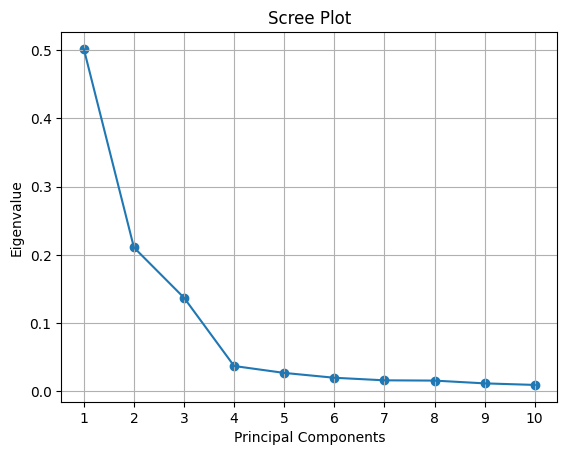

In [98]:
# Explained variance ratio
importance = pca.explained_variance_ratio_

# Scree plot
plt.scatter(range(1, len(importance) + 1), importance)
plt.plot(range(1, len(importance) + 1), importance)
plt.title('Scree Plot')
plt.xlabel('Principal Components')  
plt.ylabel('Eigenvalue')  
plt.xticks(range(1, len(importance) + 1))
plt.grid(True)
plt.show()

In [99]:
pca = PCA(n_components=3) 
principalComponents = pca.fit_transform(x)
print(sum(pca.explained_variance_ratio_))

0.8497665864236028


By look at the ratio and the plot, 3 principal components can explain 85% of the variance in the data.

In [100]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, merged_data[['Target']]], axis = 1)

finalDf.head(5)

,PC1,PC2,PC3,Target
0,-5.860558,-3.712899,-0.656258,0.005359
1,-5.841506,-3.204734,3.893148,0.031331
2,-5.802315,-2.723477,1.545864,0.009413
3,-5.729781,-2.043894,1.300535,0.007204
4,-5.669946,-1.385849,1.581684,0.000733


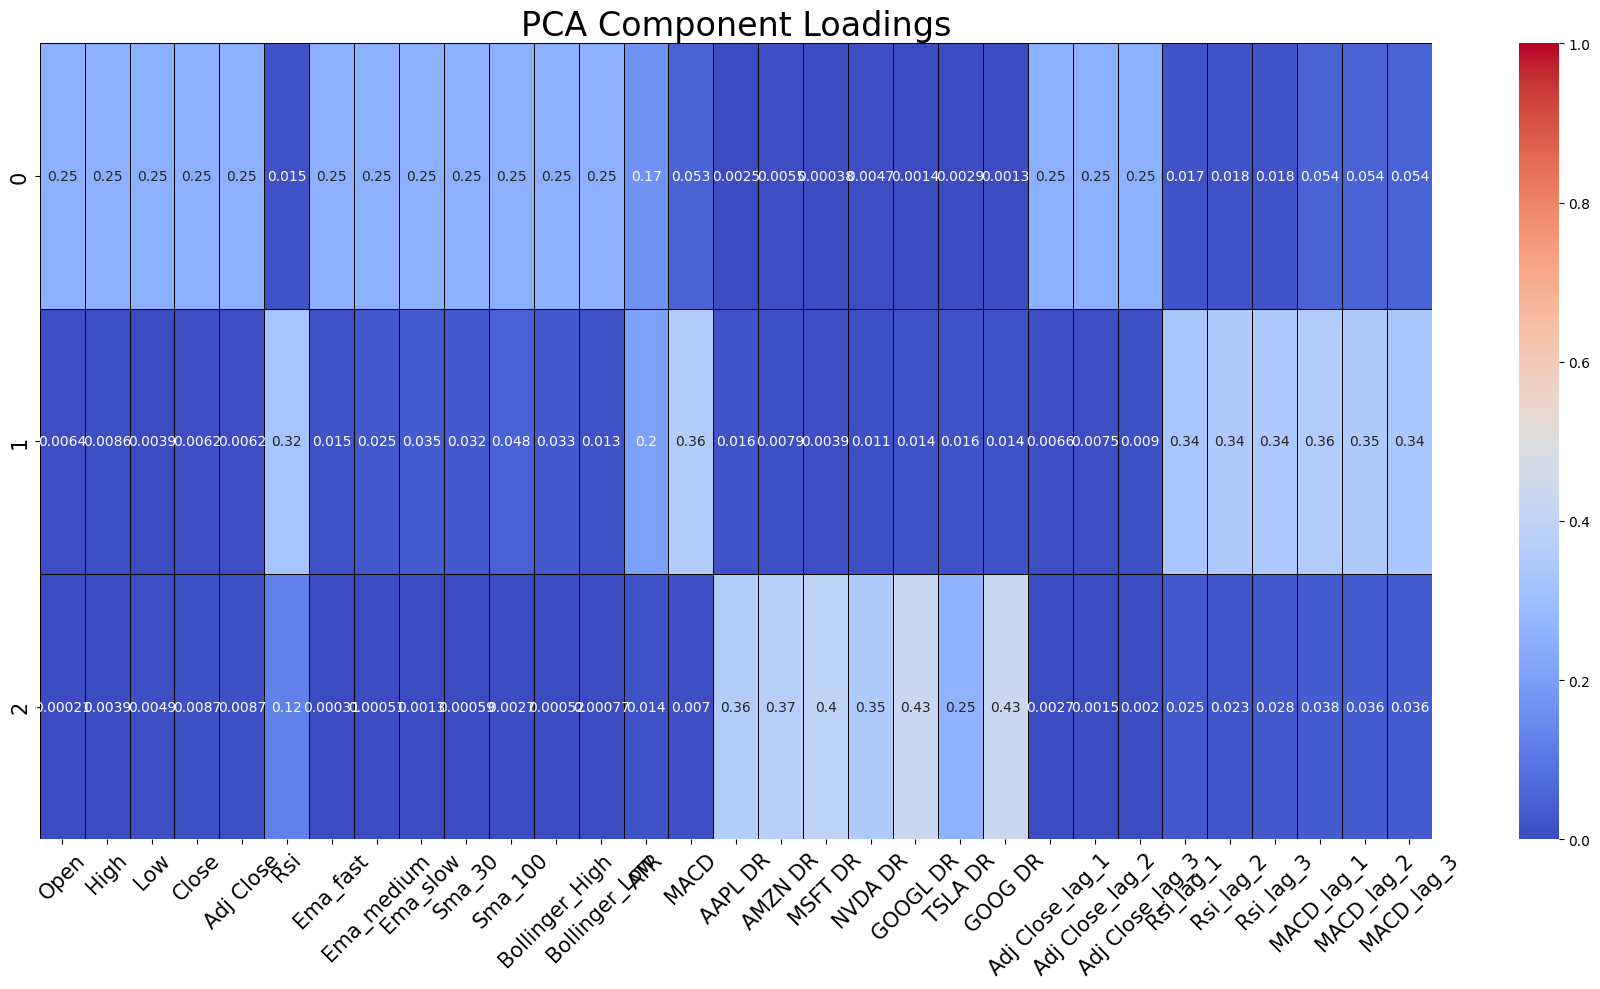

In [101]:
df_cm = pd.DataFrame(np.abs(pca.components_), columns=merged_data.columns[:-1])
plt.figure(figsize=(18, 10)) 
ax = sns.heatmap(df_cm, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='black', vmin=0, vmax=1, annot_kws={"size": 10})
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15, rotation=45)  
plt.title('PCA Component Loadings', fontsize=24)
plt.tight_layout()  
plt.show() 


Linear regression model

In [102]:
print(finalDf.head(5))
print(finalDf.shape)

        PC1       PC2       PC3    Target
0 -5.860558 -3.712899 -0.656258  0.005359
1 -5.841506 -3.204734  3.893148  0.031331
2 -5.802315 -2.723477  1.545864  0.009413
3 -5.729781 -2.043894  1.300535  0.007204
4 -5.669946 -1.385849  1.581684  0.000733
(3458, 4)


Assumption of a linear regression model is that the variance of the residual is the same for all values of X.

/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)
/var/folders/py/r18r2psx509b19yt58bj8b300000gn/T/ipykernel_3959/1705711380.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_Target'] = train_model.predict(test_data)


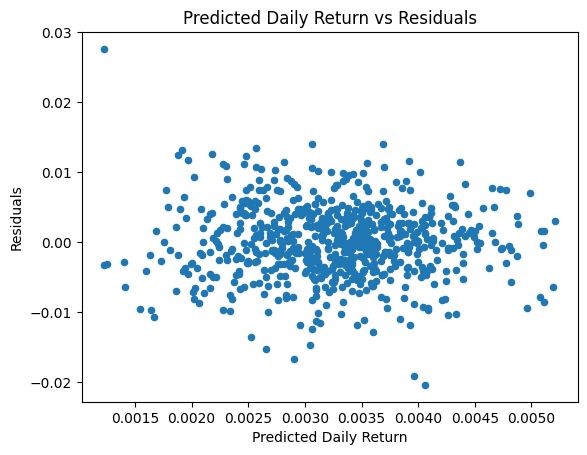

In [103]:
#train daa of merged_data
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
#get train data
train_data = finalDf.iloc[:int(0.8*len(finalDf))]
test_data = finalDf.iloc[int(0.8*len(finalDf)):]


X_with_const = finalDf.drop('Target',axis=1)
X_with_const.insert(0,'intercept',1)
train_model = sm.OLS(finalDf.Target,X_with_const, data=train_data).fit()
test_data['predicted_Target'] = train_model.predict(test_data)
# Create the summary DataFrame
mod_summary = pd.DataFrame({
    'preds': test_data['predicted_Target'],
    'resids': train_model.resid
})

# Plotting
mod_summary.plot('preds', 'resids', kind='scatter')
plt.xlabel('Predicted Daily Return')
plt.ylabel('Residuals')
plt.title('Predicted Daily Return vs Residuals')
plt.show()


The residuals appear reasonably scattered without a clear pattern.

In [104]:
import numpy as np
X = finalDf.drop(columns=['Target'])
X_std = (X - X.mean()) / X.std() # Standardize the data
y = finalDf['Target']


train_size = int(finalDf.shape[0]*0.8)
np.random.seed(123)
train_select = np.random.permutation(range(len(y)))
X_train = X_std.iloc[train_select[:train_size],:].reset_index(drop=True)
X_test = X_std.iloc[train_select[train_size:],:].reset_index(drop=True)
y_train = y[train_select[:train_size]].reset_index(drop=True)
y_test = y[train_select[train_size:]].reset_index(drop=True)

In [105]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.coef_

array([-0.00015704,  0.00042095,  0.00914867])

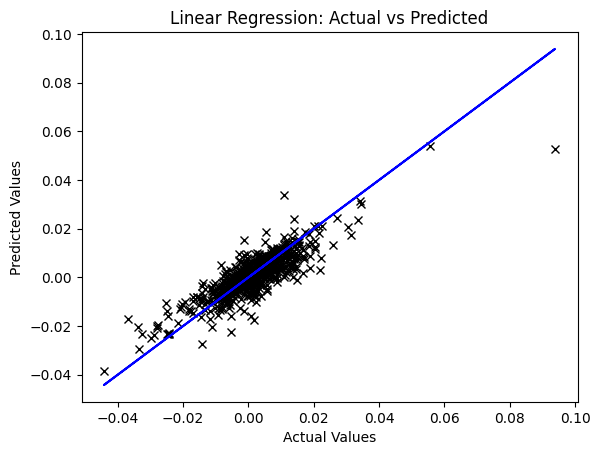

In [106]:
reg_test_pred = reg.predict(X_test)
fig = plt.figure()
plt.plot(y_test, reg_test_pred, 'kx')
plt.plot(y_test, y_test, 'b-')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

In [107]:
import numpy as np
from sklearn.metrics import r2_score

# Calculate Residual Sum of Squares (RSS)
RSS_reg = np.mean(np.square(reg_test_pred - y_test))
print("Residual Sum of Squares (RSS):", round(RSS_reg, 4))

# Calculate R-squared (R2)
R2_reg = r2_score(y_test, reg_test_pred)
print("R-squared (R2):", round(R2_reg, 4))

# Calculate Adjusted R-squared
n = len(y_test)  # Number of observations
p = X_test.shape[1]  # Number of features
Adjusted_R2_reg = 1 - (1 - R2_reg) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", round(Adjusted_R2_reg, 4))


Residual Sum of Squares (RSS): 0.0
R-squared (R2): 0.7244
Adjusted R-squared: 0.7232


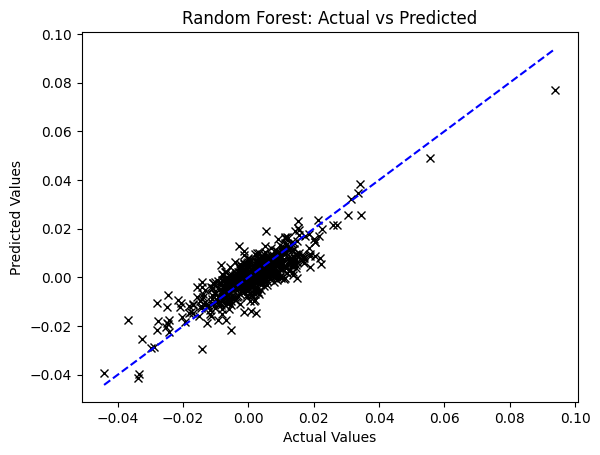

In [108]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Predict on test data
rf_test_pred = rf.predict(X_test)


# Plot actual vs predicted values
fig = plt.figure()
plt.plot(y_test, rf_test_pred, 'kx')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], ls="--", color="blue")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

In [109]:
from sklearn.metrics import r2_score
import numpy as np

# Calculate RSS for Random Forest model
RSS_rf = np.mean(np.square(rf_test_pred - y_test))
print("RSS (Random Forest):", round(RSS_rf, 4))

# R-squared (R2) for Random Forest
R2_rf = r2_score(y_test, rf_test_pred)
print("R-squared (R2) for Random Forest:", round(R2_rf, 4))

# Adjusted R-squared for Random Forest
Adjusted_R2_rf = 1 - (1 - R2_rf) * (n - 1) / (n - p - 1)
print("Adjusted R-squared for Random Forest:", round(Adjusted_R2_rf, 4))


RSS (Random Forest): 0.0
R-squared (R2) for Random Forest: 0.7478
Adjusted R-squared for Random Forest: 0.7467


Overall, the regression model seems to perform slightly better

By using rolling window means as features and shifting the target, we can turn the data into a time series forecasting problem, where we predict future values based on past observations.

In [110]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

N = 30 # using the past 30 days' data
features = finalDf[['PC1', 'PC2', 'PC3']].rolling(window=N).mean().shift(1).dropna()
target = finalDf[['PC1', 'PC2', 'PC3']].shift(-N).dropna()# shifting the target 30 days back

# Only keep rows that exist in both features and target
features, target = features.align(target, join='inner')
features = features.dropna()
target = target.dropna()

X = features.values
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print("Mean Squared Error:", round(mse, 4))
print("Root Mean Squared Error:", round(rmse, 4))
print("R-squared:", round(r_squared, 4))


Mean Squared Error: 2.1653
Root Mean Squared Error: 1.4715
R-squared: 0.475


In [114]:
# Calculate RSS for Random Forest model
RSS_rf = np.mean(pow((y_pred - y_test), 2))
print("RSS (Random Forest):", round(RSS_rf, 4))


# R-squared (R2) for Random Forest
R2_rf = r2_score(y_test, y_pred)
print("R-squared (R2) for Random Forest:", round(R2_rf, 4))

# Adjusted R-squared for Random Forest
Adjusted_R2_rf = 1 - (1 - R2_rf) * (n - 1) / (n - p - 1)
print("Adjusted R-squared for Random Forest:", round(Adjusted_R2_rf, 4))

RSS (Random Forest): 2.1653
R-squared (R2) for Random Forest: 0.475
Adjusted R-squared for Random Forest: 0.4727


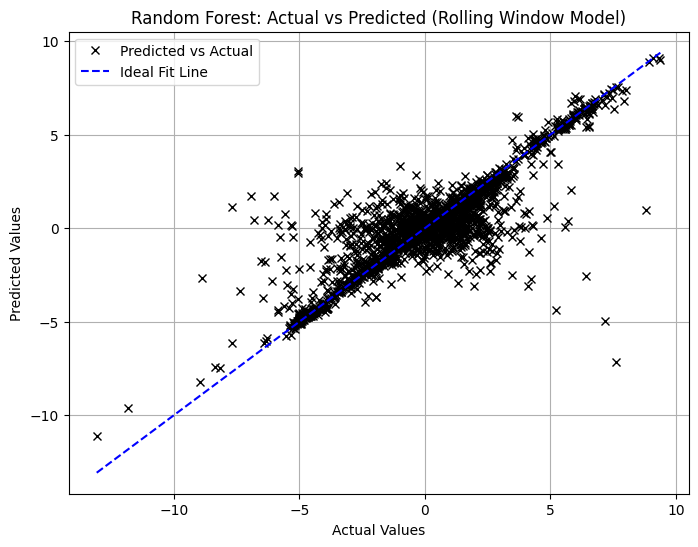

In [ ]:

plt.figure(figsize=(8, 6))
plt.plot(y_test.flatten(), y_pred.flatten(), 'kx', label="Predicted vs Actual")
plt.plot([min(y_test.flatten()), max(y_test.flatten())], [min(y_test.flatten()), max(y_test.flatten())], ls="--", color="blue", label="Ideal Fit Line")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted (Rolling Window Model)")
plt.legend()
plt.grid(True)
plt.show()

Although Linear Regression on PCs is performing the best, we believe there are complex temporal dependencies that neither Linear Regression nor Random Forest can capture, so we will use LSTM to model the data.